In [1]:
import os

def out(video_path):
    """
    Extracts the label from the full video path.
    Returns one of: "Normal", "KOA_Early", "KOA_Moderate", "KOA_Severe"
    """
    filename = os.path.basename(video_path)  
    name_parts = filename.split('_')

    if "NM" in name_parts:
        return "Normal"
    elif "KOA" in name_parts:
        severity = name_parts[-1].split('.')[0]  
        if severity == "EL":
            return "KOA_Early"
        elif severity == "MD":
            return "KOA_Moderate"
        elif severity == "SV":
            return "KOA_Severe"
    return "Unknown"


In [ ]:
import os
import cv2

def extract_frames(video_path, output_folder, frame_rate=30):
    """
    Extracts frames from a video at a fixed FPS.
    
    Args:
        video_path (str): Path to the input video file.
        output_folder (str): Path to save extracted frames.
        frame_rate (int): Number of frames per second to extract.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(round(fps / frame_rate))  # Interval between frames
    frame_count = 0
    extracted_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1
        
        frame_count += 1
    
    cap.release()
    print(f"Extracted {extracted_count} frames from {video_path}")

def process_all_videos(input_folder, output_folder, frame_rate=30):
    """
    Recursively process all videos in the input directory and extract frames.
    
    Args:
        input_folder (str): Root directory containing video files.
        output_folder (str): Root directory to save extracted frames.
        frame_rate (int): Number of frames per second to extract.
    """
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.mov', '.mp4', '.avi')):
                video_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path, os.path.splitext(file)[0])
                extract_frames(video_path, output_subfolder, frame_rate)

# Example Usage
input_folder = "Dataset"  # Update this to the actual dataset path
output_folder = "extracted_frames"
process_all_videos(input_folder, output_folder)


Extracted 214 frames from Dataset\KOA\KOA_EL\001_KOA_01_EL.MOV
Extracted 297 frames from Dataset\KOA\KOA_EL\001_KOA_02_EL.MOV
Extracted 213 frames from Dataset\KOA\KOA_EL\002_KOA_01_EL.MOV
Extracted 167 frames from Dataset\KOA\KOA_EL\002_KOA_02_EL.MOV
Extracted 227 frames from Dataset\KOA\KOA_EL\003_KOA_01_EL.MOV
Extracted 214 frames from Dataset\KOA\KOA_EL\003_KOA_02_EL.MOV
Extracted 195 frames from Dataset\KOA\KOA_EL\004_KOA_01_EL.MOV
Extracted 213 frames from Dataset\KOA\KOA_EL\004_KOA_02_EL.MOV
Extracted 159 frames from Dataset\KOA\KOA_EL\005_KOA_01_EL.MOV
Extracted 228 frames from Dataset\KOA\KOA_EL\005_KOA_02_EL.MOV
Extracted 209 frames from Dataset\KOA\KOA_EL\006_KOA_01_EL.MOV
Extracted 195 frames from Dataset\KOA\KOA_EL\006_KOA_02_EL.MOV
Extracted 168 frames from Dataset\KOA\KOA_EL\007_KOA_01_EL.MOV
Extracted 152 frames from Dataset\KOA\KOA_EL\007_KOA_02_EL.MOV
Extracted 199 frames from Dataset\KOA\KOA_EL\008_KOA_01_EL.MOV
Extracted 184 frames from Dataset\KOA\KOA_EL\008_KOA_02

In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

# Initialize Mediapipe Pose with GPU support
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, smooth_landmarks=True)

def process_frames(input_folder, output_folder):
    """
    Process all extracted frames to detect keypoints using Mediapipe Pose.
    Saves the keypoints as CSV files.

    Args:
        input_folder (str): Directory containing extracted frames.
        output_folder (str): Directory to save keypoints CSV files.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        if files:
            video_name = os.path.basename(root)
            csv_output_path = os.path.join(output_folder, f"{video_name}.csv")
            
            all_keypoints = []
            
            for file in sorted(files):  # Sort frames in order
                frame_path = os.path.join(root, file)
                image = cv2.imread(frame_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Process frame with Mediapipe
                results = pose.process(image_rgb)

                if results.pose_landmarks:
                    keypoints = []
                    for landmark in results.pose_landmarks.landmark:
                        keypoints.extend([landmark.x, landmark.y, landmark.visibility])
                    all_keypoints.append(keypoints)

            # Convert to DataFrame & save CSV
            if all_keypoints:
                df = pd.DataFrame(all_keypoints)
                df.to_csv(csv_output_path, index=False, header=False)
                print(f"Saved keypoints: {csv_output_path}")

# Set paths
input_folder = "extracted_frames"  # Folder containing extracted frames
output_folder = "pose_keypoints_mediapipe"  # Output folder for keypoints

# Run processing
process_frames(input_folder, output_folder)


Saved keypoints: pose_keypoints_mediapipe\001_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\001_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\002_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\002_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\003_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\003_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\004_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\004_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\005_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\005_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\006_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\006_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\007_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\007_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapipe\008_KOA_01_EL.csv
Saved keypoints: pose_keypoints_mediapipe\008_KOA_02_EL.csv
Saved keypoints: pose_keypoints_mediapip

In [5]:
import os
import numpy as np
import pandas as pd

# Define important landmark indices based on Mediapipe Pose
LEFT_HIP, RIGHT_HIP = 23, 24
LEFT_KNEE, RIGHT_KNEE = 25, 26
LEFT_ANKLE, RIGHT_ANKLE = 27, 28

def calculate_angle(a, b, c):
    """
    Calculate the angle between three points (a-b-c).
    """
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_gait_features(input_folder, output_folder):
    """
    Extracts gait features from pose keypoints.
    
    Args:
        input_folder (str): Directory containing keypoints CSV files.
        output_folder (str): Directory to save extracted gait features.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in os.listdir(input_folder):
        if file.endswith(".csv"):
            file_path = os.path.join(input_folder, file)
            df = pd.read_csv(file_path, header=None)

            knee_angles = []
            step_lengths = []

            for i in range(len(df)):
                keypoints = df.iloc[i].values.reshape(33, 3)  # Reshape into 33 landmarks (x, y, visibility)
                
                # Extract relevant joint positions
                left_hip, right_hip = keypoints[LEFT_HIP][:2], keypoints[RIGHT_HIP][:2]
                left_knee, right_knee = keypoints[LEFT_KNEE][:2], keypoints[RIGHT_KNEE][:2]
                left_ankle, right_ankle = keypoints[LEFT_ANKLE][:2], keypoints[RIGHT_ANKLE][:2]

                # Calculate knee joint angles
                left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
                right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

                # Calculate step length (Euclidean distance between ankles)
                step_length = np.linalg.norm(left_ankle - right_ankle)

                knee_angles.append([left_knee_angle, right_knee_angle])
                step_lengths.append(step_length)

            # Convert to DataFrame and save
            gait_df = pd.DataFrame(knee_angles, columns=["Left_Knee_Angle", "Right_Knee_Angle"])
            gait_df["Step_Length"] = step_lengths
            gait_df.to_csv(os.path.join(output_folder, file), index=False)
            print(f"Saved gait features: {file}")

# Set paths
input_folder = "pose_keypoints_mediapipe"  # Folder with keypoints
output_folder = "gait_features"  # Output folder for gait features

# Run feature extraction
extract_gait_features(input_folder, output_folder)


Saved gait features: 001_KOA_01_EL.csv
Saved gait features: 001_KOA_01_MD.csv
Saved gait features: 001_KOA_01_SV.csv
Saved gait features: 001_KOA_02_EL.csv
Saved gait features: 001_KOA_02_MD.csv
Saved gait features: 001_KOA_02_SV.csv
Saved gait features: 001_NM_01.csv
Saved gait features: 001_NM_02.csv
Saved gait features: 002_KOA_01_EL.csv
Saved gait features: 002_KOA_01_MD.csv
Saved gait features: 002_KOA_01_SV.csv
Saved gait features: 002_KOA_02_EL.csv
Saved gait features: 002_KOA_02_MD.csv
Saved gait features: 002_KOA_02_SV.csv
Saved gait features: 002_NM_01.csv
Saved gait features: 002_NM_02.csv
Saved gait features: 003_KOA_01_EL.csv
Saved gait features: 003_KOA_01_MD.csv
Saved gait features: 003_KOA_01_SV.csv
Saved gait features: 003_KOA_02_EL.csv
Saved gait features: 003_KOA_02_MD.csv
Saved gait features: 003_KOA_02_SV.csv
Saved gait features: 003_NM_01.csv
Saved gait features: 003_NM_02.csv
Saved gait features: 004_KOA_01_EL.csv
Saved gait features: 004_KOA_01_MD.csv
Saved gait

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Paths
input_folder = "gait_features"

# ✅ Updated Labeling Function for KOA Stages
def get_label(filename):
    filename = filename.upper()  # Convert to uppercase to avoid case mismatches
    
    if "_KOA" in filename:
        if "_EL" in filename:
            return 1  # KOA Early
        elif "_MD" in filename:
            return 2  # KOA Moderate
        elif "_SV" in filename:
            return 3  # KOA Severe
    return 0  # Normal


# Load all feature CSVs
X = []
y = []

for file in os.listdir(input_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(input_folder, file)
        df = pd.read_csv(file_path)
        
        # Assign the same label to all rows (frames) in the file
        label = get_label(file)
        labels = np.full((len(df),), label)  # Create array of same label
        
        X.append(df.values)  # Store feature values
        y.append(labels)  # Store labels

# Convert lists to NumPy arrays
X = np.vstack(X)  # Stack all feature arrays
y = np.concatenate(y)  # Flatten label arrays

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save processed data
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print("✅ Data Preprocessing Complete!")
print(f"📊 Data Shapes: X={X.shape}, y={y.shape}")
print("📊 Class Distribution in Training Data:", np.unique(y_train, return_counts=True))
print("📊 Class Distribution in Testing Data:", np.unique(y_test, return_counts=True))


✅ Data Preprocessing Complete!
📊 Data Shapes: X=(28164, 3), y=(28164,)
📊 Class Distribution in Training Data: (array([0, 1, 2, 3]), array([5783, 3658, 5857, 7233], dtype=int64))
📊 Class Distribution in Testing Data: (array([0, 1, 2, 3]), array([1446,  914, 1464, 1809], dtype=int64))


Traditional ML

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [38]:
# Load preprocessed data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# ✅ Convert labels to categorical (for ANN & LSTM) - 4 Classes
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# ✅ Prepare Data for ANN (Shape: [samples, features])
X_train_ann = X_train
X_test_ann = X_test

# ✅ Prepare Data for LSTM (Reshape: [samples, time_steps, features_per_step])
num_features = X_train.shape[1]

# Dynamically find a valid `time_steps` (e.g., 5, 10, 15) that evenly divides `num_features`
for ts in range(2, 21):  # Test time_steps from 2 to 20
    if num_features % ts == 0:
        time_steps = ts
        break

features_per_step = num_features // time_steps  # Ensures divisibility

# Reshape input for LSTM
X_train_lstm = X_train.reshape(-1, time_steps, features_per_step)
X_test_lstm = X_test.reshape(-1, time_steps, features_per_step)

print(f"LSTM Shape {X_train_lstm.shape} (Time Steps: {time_steps})")


✅ Data Ready: ANN Shape (22531, 3), LSTM Shape (22531, 3, 1) (Time Steps: 3)


LSTM

In [6]:
import numpy as np

y_train = np.load("y_train.npy")  # Load labels
unique, counts = np.unique(y_train, return_counts=True)



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Load preprocessed data
X_train_lstm = np.load("X_train.npy").reshape(-1, 3, 1)  # Reshape for LSTM
X_test_lstm = np.load("X_test.npy").reshape(-1, 3, 1)
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', recurrent_dropout=0.2), input_shape=(3, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False, activation='tanh', recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\storm\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Train Model
history = lstm_model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7157 - loss: 0.6213 - val_accuracy: 0.8021 - val_loss: 0.4789
Epoch 2/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7772 - loss: 0.5067 - val_accuracy: 0.8065 - val_loss: 0.4560
Epoch 3/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7880 - loss: 0.4871 - val_accuracy: 0.8063 - val_loss: 0.4585
Epoch 4/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7888 - loss: 0.4834 - val_accuracy: 0.8191 - val_loss: 0.4487
Epoch 5/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7984 - loss: 0.4784 - val_accuracy: 0.8150 - val_loss: 0.4498
Epoch 6/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7952 - loss: 0.4747 - val_accuracy: 0.8175 - val_loss: 0.4425
Epoch 7/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7997 - loss: 0.4696 - val_accuracy: 0.8230 - val_loss: 0.4384
Epoch 8/50
705/705 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7987 - loss: 0.4728 - val_accuracy: 0

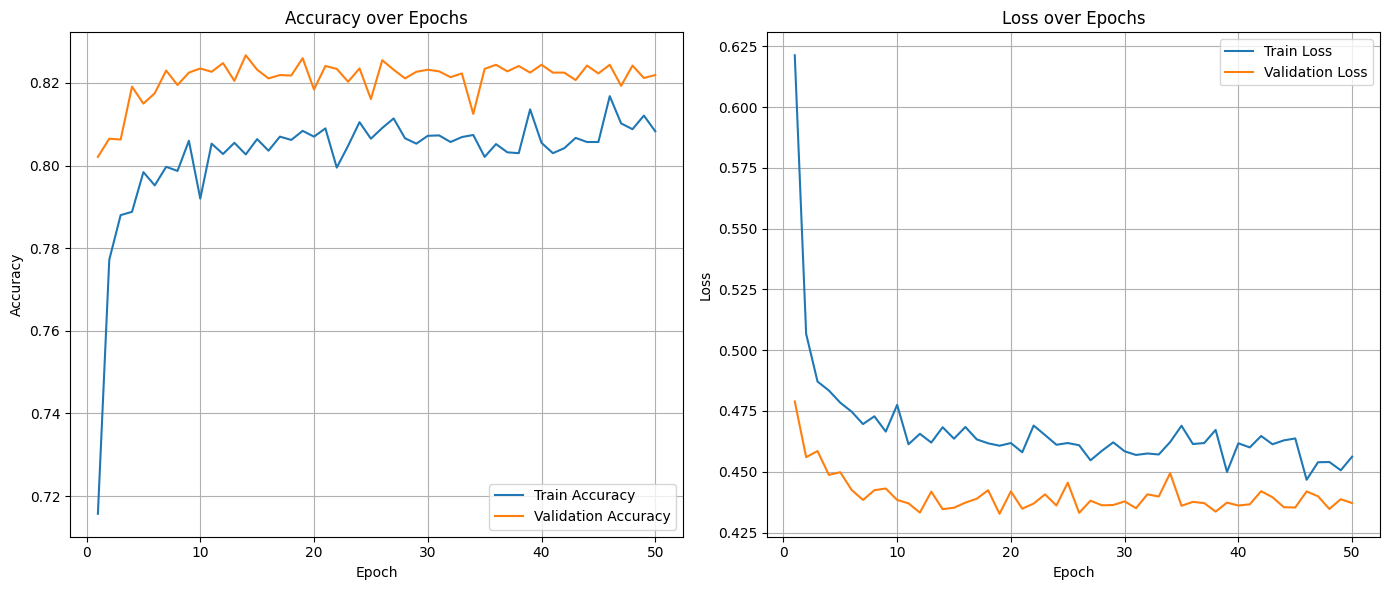

: 

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 51))

# Extracted from the training log
train_accuracy = [
    0.7157, 0.7772, 0.7880, 0.7888, 0.7984, 0.7952, 0.7997, 0.7987, 0.8060, 0.7920,
    0.8053, 0.8028, 0.8055, 0.8027, 0.8064, 0.8036, 0.8070, 0.8062, 0.8084, 0.8070,
    0.8090, 0.7995, 0.8048, 0.8105, 0.8065, 0.8091, 0.8114, 0.8066, 0.8053, 0.8072,
    0.8073, 0.8057, 0.8069, 0.8074, 0.8021, 0.8052, 0.8032, 0.8030, 0.8136, 0.8055,
    0.8030, 0.8042, 0.8067, 0.8057, 0.8057, 0.8168, 0.8102, 0.8088, 0.8121, 0.8083
]

val_accuracy = [
    0.8021, 0.8065, 0.8063, 0.8191, 0.8150, 0.8175, 0.8230, 0.8195, 0.8225, 0.8235,
    0.8227, 0.8248, 0.8205, 0.8267, 0.8232, 0.8211, 0.8219, 0.8218, 0.8260, 0.8184,
    0.8241, 0.8234, 0.8203, 0.8235, 0.8161, 0.8255, 0.8232, 0.8211, 0.8227, 0.8232,
    0.8228, 0.8214, 0.8223, 0.8125, 0.8234, 0.8244, 0.8228, 0.8241, 0.8225, 0.8244,
    0.8225, 0.8225, 0.8207, 0.8242, 0.8223, 0.8244, 0.8193, 0.8242, 0.8212, 0.8219
]

train_loss = [
    0.6213, 0.5067, 0.4871, 0.4834, 0.4784, 0.4747, 0.4696, 0.4728, 0.4665, 0.4775,
    0.4613, 0.4656, 0.4620, 0.4683, 0.4636, 0.4684, 0.4633, 0.4617, 0.4607, 0.4618,
    0.4580, 0.4690, 0.4651, 0.4611, 0.4618, 0.4609, 0.4547, 0.4586, 0.4621, 0.4584,
    0.4569, 0.4575, 0.4571, 0.4622, 0.4689, 0.4614, 0.4618, 0.4672, 0.4499, 0.4617,
    0.4600, 0.4647, 0.4613, 0.4629, 0.4637, 0.4467, 0.4539, 0.4540, 0.4506, 0.4562
]

val_loss = [
    0.4789, 0.4560, 0.4585, 0.4487, 0.4498, 0.4425, 0.4384, 0.4424, 0.4431, 0.4384,
    0.4370, 0.4332, 0.4418, 0.4346, 0.4352, 0.4373, 0.4389, 0.4424, 0.4327, 0.4419,
    0.4348, 0.4369, 0.4407, 0.4361, 0.4455, 0.4331, 0.4381, 0.4362, 0.4363, 0.4378,
    0.4350, 0.4407, 0.4398, 0.4494, 0.4360, 0.4376, 0.4371, 0.4336, 0.4373, 0.4361,
    0.4366, 0.4420, 0.4395, 0.4354, 0.4353, 0.4419, 0.4399, 0.4347, 0.4387, 0.4371
]

# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# Evaluate Model
y_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 LSTM Model Performance:")
print(classification_report(y_true, y_pred, target_names=["NM", "KOA"]))


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📊 LSTM Model Performance:
              precision    recall  f1-score   support

          NM       0.74      0.43      0.54      1389
         KOA       0.84      0.95      0.89      4244

    accuracy                           0.82      5633
   macro avg       0.79      0.69      0.72      5633
weighted avg       0.81      0.82      0.80      5633



In [30]:
# Save Model
lstm_model.save("lstm_model.h5")
print("✅ LSTM Model Saved: lstm_model.h5")

✅ LSTM Model Saved: lstm_model.h5


Deployment

In [3]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import joblib
import pandas as pd
from tensorflow.keras.models import load_model

# Load the best-trained model (ANN or LSTM)
MODEL_PATH = "D:\\8th Sem\\Major Project\\lstm_model.h5"  # Change to "best_lstm_model.h5" if using LSTM
model = load_model(MODEL_PATH)

# Load label encoder (for severity classification)
label_encoder = {0: "Normal", 1: "KOA_Early", 2: "KOA_Moderate", 3: "KOA_Severe"}

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, smooth_landmarks=True)

# Define important joint indices (Mediapipe)
LEFT_HIP, RIGHT_HIP = 23, 24
LEFT_KNEE, RIGHT_KNEE = 25, 26
LEFT_ANKLE, RIGHT_ANKLE = 27, 28

# Function to calculate angles between three points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# Process video and extract gait features
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    gait_features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            keypoints = np.array([[lm.x, lm.y] for lm in landmarks])

            left_hip, right_hip = keypoints[LEFT_HIP], keypoints[RIGHT_HIP]
            left_knee, right_knee = keypoints[LEFT_KNEE], keypoints[RIGHT_KNEE]
            left_ankle, right_ankle = keypoints[LEFT_ANKLE], keypoints[RIGHT_ANKLE]

            # Compute gait features
            left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
            step_length = np.linalg.norm(left_ankle - right_ankle)

            gait_features.append([left_knee_angle, right_knee_angle, step_length])

    cap.release()

    # Convert to numpy array and average features across frames
    if gait_features:
        gait_features = np.mean(gait_features, axis=0).reshape(1, -1)
    else:
        print("❌ No valid frames detected!")
        return None

    return gait_features

# Classify video
def classify_video(video_path):
    features = process_video(video_path)
    if features is None:
        print("❌ Classification failed: No valid features extracted!")
        return

    # Predict using the trained model
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction)
    label = out(video_path)
    print(f"✅ Classification: {label} (Confidence: {confidence:.2f})")

# Example Usage
video_path = "Dataset_Split\\test\\NM\\025_NM_01.MOV"  # Change to your video file path
classify_video(video_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
✅ Classification: Normal (Confidence: 0.84)
